# 18.S097/16.S092 Problem Set 3

Due Saturday 4/26 at **11:59pm**; 20% penalty if it is turned in within 24 hours, and after that late psets will not be accepted without prior arrangement.   Submit in PDF format: a decent-quality scan/image of any handwritten solutions (e.g. get a scanner app on your phone or use a tablet), combined with a PDF printout of your Jupyter notebook showing your code and (clearly labeled) results.

**TO GENERATE A PDF OF YOUR JUPYTER NOTEBOOK:** In the Jupyter client (e.g. the [JupyterLab Desktop](https://github.com/jupyterlab/jupyterlab-desktop) app), in the *File* pull-down menu, select *Save and Export Notebook As*, and then select the *HTML* format (not PDF, which may require special software).  Then open the downloaded HTML file with your favorite browser, and use the browser's *Print* function to generate the PDF file.

## Problem 1 (5+3+5+10 points)

One way to find maximum/minimum eigenvalues of a real-symmetric matrix $A=A^T$ is to apply an optimization algorithm, such as gradient ascent/descent, to maximize/minimize the Rayleigh quotient $R(x)$:
$$
R(x) = \frac{x^T A x}{x^T x} \implies \cdots \implies \nabla R = \frac{2}{x^T x} \left( Ax - R(x) x \right)
$$
where you know from calculus that the gradient $\nabla R$ is the "uphill" (steepest ascent) direction.

Ordinary gradient ascent works by starting with a guess $x_k$ and taking a step $x_{k+1} = x_k + s d_k$ in the uphill direction $d = \left. \nabla R \right|_{x_k}$, with a step size ("learning rate") $s$ that varies depending on the algorithm.    The "optimal" $s$ would be the one that maximizes $R(x_k + s d_k)$, corresponding to a 1d "line maximization", but most generic optimization algorithms use some approximation of this.  For this specific function $R(x)$, however, it turns out that we can determine the optimal $s$ by solving a $2 \times 2$ eigenproblem!

More generally, it turns out that one can *specialize* optimization algorithms for $R(x)$ and do much better (an insight that ultimately leads to the [LOBPCG algorithm](https://en.wikipedia.org/wiki/LOBPCG)).  In this problem, you will explore one aspect of this idea.

**(a)** Consider the $6 \times 6$ real-symmetric matrix $A$ given below in Julia notation.  Suppose we start at an arbitrary point, say $x = [1,2,3,4,5,6]$ and want to explore the line $x + s d$ for some arbitrary direction, say $d = [2, -1, 2, 2, -2, 0]$.  Plot $R(x + sd)$ for this $A, x, d$ as a function of $s$ (for a wide enough range to clearly show the behavior).  Is the result consistent with the min-max theorem $\lambda_{\min} \le R(x) \le \lambda_{\max}$?

**(b)** Identify roughly (to several decimal digits), by brute force search (e.g. evaluate a million $s$ points), the $s$ where $R(x + sd)$ is maximum.  Give this value of $s$, and show it as a dot on your plot from the previous part.

**(c)** Explain why the following equality holds for any vectors $x, d \ne 0$ and any real-symmetric $A$:
$$
\max_{s \in \mathbb{R}} R(x + sd) = \max_{\alpha, \beta \in \mathbb{R}} R(\alpha x + \beta d) = \max_{y \in \operatorname{span}\{x,d\}} R(y)
$$
(Hint: what is the relationship between $R(x)$ and $R(\alpha x)$ for a scalar $\alpha$?)

**(d)** The Rayleigh–Ritz procedure from class allows us to maximize $R(y)$ over any $d$-dimensional subspace by solving a $d \times d$ eigenproblem.  Find (numerically) an orthormal basis $Q = \begin{pmatrix}q_1  & q_2 \end{pmatrix}$ for the span of the $x,d$ from (a), e.g. by Gram–Schmidt.   Apply the Rayleigh–Ritz procedure to obtain a $2 \times 2$ eigenproblem that gives you the $y = Qz$ maximizing $R(y)$ for $y \in C(Q)$, and find this $y$ numerically (calling a $2 \times 2$ eigensolver).  Work backwards to find α,β  coefficients $y = \alpha x + \beta d = \alpha (x + (\beta/\alpha) d)$, and in doing so obtain the optimal $s = \beta/\alpha$. Compare this to your answer from (b): they should (roughly) match! 

**Recommended exercise (not required):** implement a few steps of gradient ascent with $d = \nabla R$, computing the optimal step size $s$ from the 2x2 eigenproblem at each step, and see how quickly it converges to $\lambda_{\max}$.

In [18]:
A = [-6  1  0  2  0 -1
      1  8 -1  6 -3  0
      0 -1  8  2 -6 -3
      2  6  2 -8  3  2
      0 -3 -6  3  8 -2
     -1  0 -3  2 -2  8]

6×6 Matrix{Int64}:
 -6   1   0   2   0  -1
  1   8  -1   6  -3   0
  0  -1   8   2  -6  -3
  2   6   2  -8   3   2
  0  -3  -6   3   8  -2
 -1   0  -3   2  -2   8

In [19]:
x = [1, 2, 3, 4, 5,  6]
d = [2, -1, 2, 2, -2, 0];

## Solutions:

**(a)**

In [20]:
using LinearAlgebra
λmin, λmax = extrema(eigvals(A))

(-12.24124382495759, 14.413517800855841)

smax = argmax((s->begin
                #= In[23]:8 =#
                R(x + s * d)
            end), range(-2, 0, length = 10 ^ 6)) = -1.5896755896755896


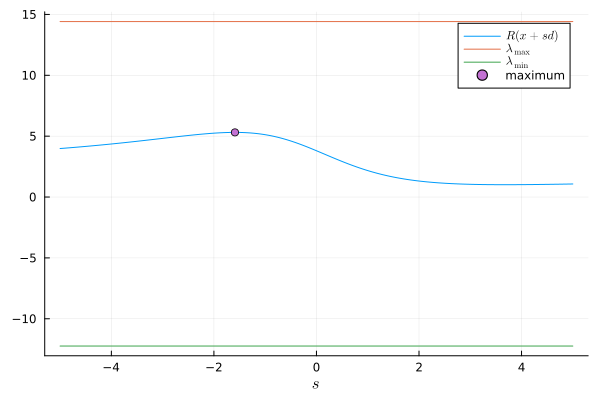

In [23]:
using Plots, LaTeXStrings
R(x) = x'*A*x / x'x
s = range(-5,5, length=1000)
plot(s, [R(x + s*d) for s in s], label=L"R(x+sd)", xlabel=L"s")
plot!(s, fill(λmax, length(s)), label=L"\lambda_{\max}")
plot!(s, fill(λmin, length(s)), label=L"\lambda_{\min}")

@show smax = argmax(s -> R(x + s*d), range(-2,0, length=10^6))
scatter!([smax], [R(x + smax*d)], label="maximum")

In [28]:
Q = Matrix(qr([x d]).Q)
F = eigen(Q'*A*Q)
z = F.vectors[:,2]
y = Q*z
α, β = [x d] \ y
@show β/α

β / α = -1.5896751154893443


-1.5896751154893443

In [29]:
β/α / smax

0.9999997017087962

## Problem 2 (10 points)

In class, we applied GMRES to $Ax=b$ by forming an orthonormal basis $Q_n$ of the Krylov space $\mathcal{K}_n = \operatorname{span} \{ b, Ab, A^2b, \ldots, A^{n-1}b \}$ by an Arnoldi-like process.  Then, minimizing $\Vert Ax - b \Vert_2$ for $x \in \mathcal{K}_n = C(Q_n)$ was reduced to a tiny $(n+1) \times n$ least-squares problem.

Instead, suppose that we have a starting guess $x_0$ for the solution (perhaps from an earlier result of a truncated/restarted GMRES process, or perhaps from solving a slightly different matrix or right-hand-side), and we want to exploit it.  We want to devise a new GMRES process that makes use of $x_0$, but make sure that (1) our solution is at *least* as good as $x_0$ on subsequent steps (i.e. $x_0$ must be a possible solution) and (2) it still reduces to a tiny $(n+1) \times n$ least-squares problem.

It turns out that a good way to proceed is to instead use the *residual* $r = b - Ax_0$ as the starting vector of our Krylov space and Arnoldi process (with $r=b$ the special case where $x_0 = 0$).   Show that if we then minimize $\Vert A(x_0 + y) - b \Vert_2$ over $y$ in this new Krylov space, the resulting solution $x = x_0 + y$ satisfies the two desired properties above.

## Problem 3 (5+5+5+5 points)

(From [FNC book, section 8.5.4, exercise 5](https://fncbook.com/gmres#exercises).)

In this exercise you will see the strong effect the eigenvalues of the matrix may have on GMRES convergence. Let 
   
$$
    \mathbf{B}=
    \begin{bmatrix}
      1 & & & \\
      & 2 & & \\
      & & \ddots & \\
      & & & 100
    \end{bmatrix},
$$ 

Let $\mathbf{I}$ be a $100\times 100$ identity, and let $\mathbf{Z}$ be a $100\times 100$ matrix of zeros. Also let $\mathbf{b}$ be a $200\times 1$ vector of ones. You will use **GMRES with restarts** via a pre-existing library function, as in the [FNC book demo 8.5.2](https://fncbook.com/gmres#demo-gmres-restart) (which has examples in Julia and Python).

**(a)** Let $\mathbf{A} = \begin{bmatrix} \mathbf{B} & \mathbf{I} \\ \mathbf{Z} & \mathbf{B} \end{bmatrix}.$ What are its eigenvalues?  You can use a computer to check your answers, but you should be able to explain the eigenvalues analytically (with no calculation).

**(b)** Apply `gmres` to the matrix from (a) with tolerance $10^{-10}$ for 100 iterations without restarts, and plot the residual convergence vs. iteration (on a semilog scale).
    
**(c)** Repeat part (a) with restarts every 20 iterations. 
    
**(d)** Now let $\mathbf{A} = \begin{bmatrix} \mathbf{B} & \mathbf{I} \\ \mathbf{Z} & -\mathbf{B} \end{bmatrix}.$ What are its eigenvalues? Repeat parts (b) and (c) for the new matrix. Which matrix is more difficult for GMRES?

(Note: Even though this matrix is triangular, GMRES has no way of exploiting that fact.  A sparse-direct solve on this matrix would be $O(N)$.)


## Problem 4 (5+5+5+5 points)

From [FNC book, section 8.5.4, exercise 6](https://fncbook.com/gmres#exercises).

This problem again uses FNC's `poisson(n)` function from problem 3 of problem set 2.  We again consider the $n^2\times n^2$ sparse matrix defined by `poisson(n)`. The solution of $\mathbf{A}\mathbf{x}=\mathbf{b}$ may be interpreted as the deflection of a lumped membrane in response to a load (external forces) represented by $\mathbf{b}$.
    
**(a)** For $n=10,15,20,25$, let $\mathbf{b}$ be the vector of all (i.e., $n^2$) $-1$ values and apply non-restarted `gmres` (again using a library function as in the previous problem) for 50 iterations. On one semi-log graph, plot the four convergence curves $\|\mathbf{r}_m\|/\|\mathbf{b}\|$.

**(b)** For the case $n=25$ make a surface plot of the solution `x` (converged to many digits) after reshaping it to a 25×25 matrix. It should look physically plausible for stretched membrane experiencing a constant downward force at every point (e.g. gravity).